# Movinet Streaming Model Fine Tuning

## Install cecessary libraries

In [1]:
!pip uninstall numpy tensorflow pandas
!pip install numpy==1.26.4 tensorflow==2.18.0 pandas==2.2.2
!pip install tensorflow-model-optimization tf-models-official tensorflow-text google-colab
!pip install remotezip

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-package

## Import necessary libraries

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tf_keras import callbacks, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Import the MoViNet model from TensorFlow Models (tf-models-official)

In [3]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

## Download Subdataset of UCF_101

In [7]:
!gdown 1EdHlvTgorxMZZJt6DbCVp-MNDPZAw09p
!unzip "UCF101_split_no_augment_with_val.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1EdHlvTgorxMZZJt6DbCVp-MNDPZAw09p
From (redirected): https://drive.google.com/uc?id=1EdHlvTgorxMZZJt6DbCVp-MNDPZAw09p&confirm=t&uuid=4a643ad6-e747-4916-b9a9-5c194e0ddbe4
To: /content/UCF101_split_no_augment_with_val.zip
100% 717M/717M [00:08<00:00, 84.2MB/s]
Archive:  UCF101_split_no_augment_with_val.zip
   creating: UCF101_split_with_val_2/
   creating: UCF101_split_with_val_2/test/
   creating: UCF101_split_with_val_2/test/Archery/
  inflating: UCF101_split_with_val_2/test/Archery/v_Archery_g25_c06.mp4  
  inflating: UCF101_split_with_val_2/test/Archery/v_Archery_g13_c06.mp4  
  inflating: UCF101_split_with_val_2/test/Archery/v_Archery_g02_c01.mp4  
  inflating: UCF101_split_with_val_2/test/Archery/v_Archery_g19_c03.mp4  
  inflating: UCF101_split_with_val_2/test/Archery/v_Archery_g23_c07.mp4  
  inflating: UCF101_split_with_val_2/test/Archery/v_Archery_g13_c03.mp4  
  inflating: UCF101_split_with_val_2/test/Archery/v_Arc

## Prepare train, valid and test dataset

In [23]:
def frames_from_video_file(video_path, n_frames, frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(tf.image.convert_image_dtype(frame, tf.float32))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = tf.image.convert_image_dtype(frame, tf.float32)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, class_ids_for_name, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_ids_for_name = class_ids_for_name

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name]
      print(f"{label} is for {name}")
      yield video_frames, label

In [24]:
train_path = Path("/content/UCF101_split_with_val_2/train")
test_path = Path("/content/UCF101_split_with_val_2/test")
val_path = Path("/content/UCF101_split_with_val_2/val")
batch_size = 8
num_frames = 8

class_names = sorted(set(p.name for p in train_path.iterdir() if p.is_dir()))
class_ids_for_name = dict((name, idx) for idx, name in enumerate(class_names))

In [25]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

# Train dataset
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path,
                                                         class_ids_for_name,
                                                         num_frames,
                                                         training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

# Validation dataset
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path,
                                                       class_ids_for_name,
                                                       num_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

# Test dataset
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path,
                                                        class_ids_for_name,
                                                        num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [22]:
np.save("../labels.npy", np.array(list(class_ids_for_name)))

### Check the prepared training batch of the data

In [27]:
class_ids_for_name

{'ApplyEyeMakeup': 0,
 'ApplyLipstick': 1,
 'Archery': 2,
 'BaseballPitch': 3,
 'Basketball': 4,
 'BenchPress': 5,
 'Biking': 6,
 'Billiards': 7,
 'BlowDryHair': 8,
 'BlowingCandles': 9,
 'Diving': 10,
 'GolfSwing': 11,
 'PullUps': 12,
 'PushUps': 13,
 'SoccerPenalty': 14,
 'TennisSwing': 15}

In [26]:
for frames, labels in train_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

2 is for Archery
4 is for Basketball
11 is for GolfSwing
5 is for BenchPress
11 is for GolfSwing
15 is for TennisSwing
2 is for Archery
2 is for Archery
Shape: (8, 8, 172, 172, 3)
Label: (8,)


### Set up the distribution strategy

In [11]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Construct the backbone for Movinet

In [12]:
# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

movinet_a0_stream/
movinet_a0_stream/ckpt-1.data-00000-of-00001
movinet_a0_stream/ckpt-1.index
movinet_a0_stream/checkpoint


In [13]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

### Load pre-trained checkpoint and modify classifier

In [14]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():

  model = build_classifier(batch_size, num_frames, 172, backbone, len(class_names))
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = optimizers.legacy.Adam(learning_rate=0.0001)

  checkpoint_dir = 'movinet_a0_stream'
  checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
  checkpoint = tf.train.Checkpoint(backbone=backbone)
  status = checkpoint.restore(checkpoint_path).expect_partial()

  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

## Create a callback for storing the checkpoints

In [15]:
checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "best_model.weights.h5")

# Checkpoint callback to save best model
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        verbose=1)

# Early stopping callback to stop if model can't improve
es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1,
                                      mode='auto',
                                      baseline=None,
                                      start_from_epoch=0)

# Schedule to adjust learning rate
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## Train the model

In [16]:
results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback, es_callback, lr_scheduler])

Epoch 1/20
    189/Unknown - 82s 222ms/step - loss: 2.2752 - accuracy: 0.2970
Epoch 1: saving model to /content/checkpoints/best_model.weights.h5
189/189 [==============================] - 101s 322ms/step - loss: 2.2752 - accuracy: 0.2970 - val_loss: 2.4876 - val_accuracy: 0.1988 - lr: 1.0000e-04
Epoch 2/20
189/189 [==============================] - ETA: 0s - loss: 1.9735 - accuracy: 0.3654
Epoch 2: saving model to /content/checkpoints/best_model.weights.h5
189/189 [==============================] - 49s 259ms/step - loss: 1.9735 - accuracy: 0.3654 - val_loss: 2.0140 - val_accuracy: 0.3547 - lr: 1.0000e-04
Epoch 3/20
189/189 [==============================] - ETA: 0s - loss: 1.7228 - accuracy: 0.4478
Epoch 3: saving model to /content/checkpoints/best_model.weights.h5
189/189 [==============================] - 49s 259ms/step - loss: 1.7228 - accuracy: 0.4478 - val_loss: 1.6339 - val_accuracy: 0.4771 - lr: 1.0000e-04
Epoch 4/20
189/189 [==============================] - ETA: 0s - loss: 1.

## Plot loss

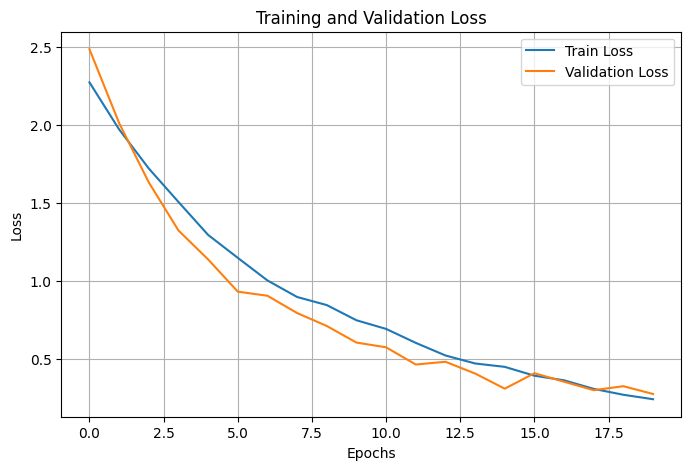

In [17]:
%matplotlib inline
# Plot loss and accuracy over epoch
history = results.history
train_loss = history['loss']
val_loss = history['val_loss']

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Evaluate the model

In [18]:
model.evaluate(test_ds)

42/42 [==============================] - 8s 190ms/step - loss: 0.3001 - accuracy: 0.9251


[0.3000788986682892, 0.92514967918396]

## Reconstruct the whole model with `use_external_states=True` to make the inference using states.

In [ ]:
# model_id = 'a2'
# use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
# resolution = 224

# # Create backbone and model.
# backbone = movinet.Movinet(
#     model_id=model_id,
#     causal=True,
#     conv_type='2plus1d',
#     se_type='2plus3d',
#     activation='hard_swish',
#     gating_activation='hard_sigmoid',
#     use_positional_encoding=use_positional_encoding,
#     use_external_states=True,
# )

# model = movinet_model.MovinetClassifier(
#     backbone,
#     num_classes=10,
#     output_states=True)

# # Create your example input here.
# # Refer to the paper for recommended input shapes.
# inputs = tf.ones([1, 13, 224, 224, 3])

# # [Optional] Build the model and load a pretrained checkpoint.
# model.build(inputs.shape)

# # Load weights from the checkpoint to the rebuilt model
# checkpoint_dir = 'trained_model'
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

## Inference using external states

In [ ]:
def get_top_k(probs, k=5, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

In [ ]:
# # Create initial states for the stream model
# init_states_fn = model.init_states
# init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, 224, 224, 3])))

# all_logits = []

# # To run on a video, pass in one frame at a time
# states = init_states
# for frames, label in test_ds.take(1):
#   for clip in frames[0]:
#     clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
#     logits, states = model.predict({**states, 'image': clip}, verbose=0)
#     all_logits.append(logits)

# logits = tf.concat(all_logits, 0)
# probs = tf.nn.softmax(logits)

# final_probs = probs[-1]
# top_k = get_top_k(final_probs)
# print()
# for label, prob in top_k:
#   print(label, prob)

# frames, label = list(test_ds.take(1))[0]
# to_gif(frames[0].numpy())

## Export to saved model

In [ ]:
# saved_model_dir = 'model'
# tflite_filename = 'model.tflite'
# input_shape = [1, 1, 224, 224, 3]

# # Convert to saved model
# export_saved_model.export_saved_model(
#     model=model,
#     input_shape=input_shape,
#     export_path=saved_model_dir,
#     causal=True,
#     bundle_input_init_states_fn=False)